# Часть 2

1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

Для выполнения 2 части работы возьмем задачу с **локализацией объекта**

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python
#установим все необходимые библиотеки для работы

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-20vd03s3
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-20vd03s3
  Resolved https://github.com/albumentations-team/albumentations to commit 2bc1c14bc14463df085145fc9e632a0256adc4f9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("imsparsh/flowers-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2


In [ ]:
import os

# проверим содержимое папки
print(os.listdir("/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2"))


['test', 'sample_submission.csv', 'train', 'LICENSE.txt', 'Testing_set_flower.csv']


In [ ]:
csv_file = "/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2/Testing_set_flower.csv"
data_dir = "/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2/test"

In [ ]:
import os

# проверим содержимое папки test
test_images = os.listdir(data_dir)

# выведем первые 5 изображений, чтобы убедиться, что данные есть
print(test_images[:5])


['Image_246.jpg', 'Image_471.jpg', 'Image_399.jpg', 'Image_347.jpg', 'Image_342.jpg']


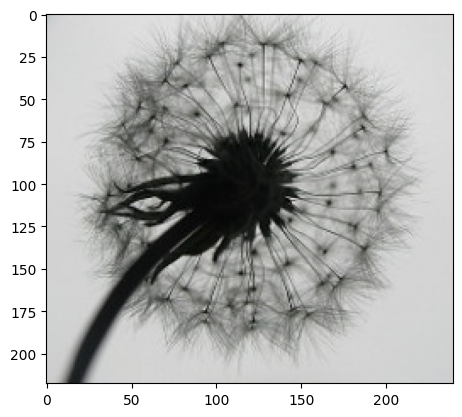

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path = os.path.join(data_dir, test_images[0])  # Берем первое изображение

# отображаем изображение
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()


In [ ]:
height, width, channels = image.shape
print(f"Размер изображения: {width}x{height}, Количество каналов: {channels}")

Размер изображения: 240x218, Количество каналов: 3


Для проведения тестирования локализации без предварительно заданных аннотаций в выбранном датасете, мы можем использовать предварительно обученную модель, такую как **Faster R-CNN**, чтобы получить координаты объектов. Координаты, полученные от модели, мы задействуем для рисования bounding box на изображении.  

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


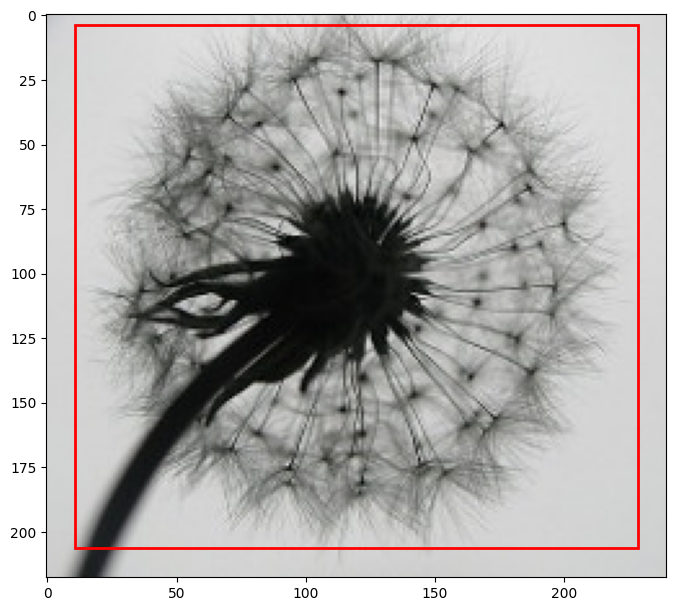

In [ ]:
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
import matplotlib.pyplot as plt

# загружаем предварительно обученную модель Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

image_path = '/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2/test/Image_246.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# преобразование изображения в формат, подходящий для модели
image_tensor = F.to_tensor(image).unsqueeze(0)

# предсказания модели
with torch.no_grad():
    prediction = model(image_tensor)

# выбираем bounding box с наибольшей вероятностью, чтобы избежать наложения нескольких сразу
scores = prediction[0]['scores']
max_score_idx = torch.argmax(scores)
box = prediction[0]['boxes'][max_score_idx].numpy()

# результат с bounding box
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)

xmin, ymin, xmax, ymax = box
ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'))

plt.show()


In [ ]:
df = pd.read_csv(csv_file)
df

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
...,...
919,Image_920.jpg
920,Image_921.jpg
921,Image_922.jpg
922,Image_923.jpg


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Гиперпараметры

In [ ]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
batch_size_value = 16
image_size = 172
learning_rate = 0.001
num_epochs = 40
model_choice = "efficientnet_b0"
num_cor = 4

Аугментация данных

Размер изображения: 172x240, Количество каналов: 3


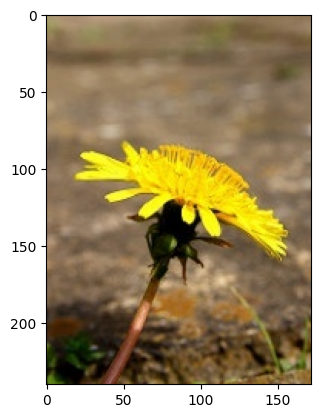

In [ ]:
image_path = '/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2/test/Image_111.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, channels = image.shape
print(f"Размер изображения: {width}x{height}, Количество каналов: {channels}")

plt.imshow(image)

In [ ]:
import albumentations as A
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, Rotate, Normalize
from albumentations.pytorch import ToTensorV2
from albumentations import BboxParams

# параметры для аугментации
img_size = 172

# Аугментация (для тренировки)
train_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

# Аугментация (для валидации)
val_augs = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

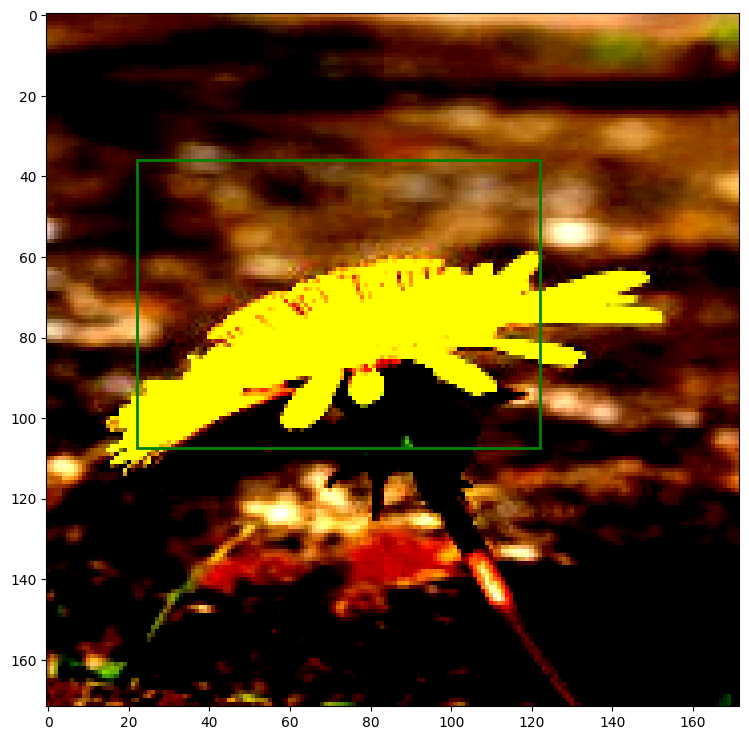

In [ ]:
image_path = '/root/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2/test/Image_111.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes = [[50, 50, 150, 150]]
class_labels = ['flower']  # метка для объекта

# применим аугментацию
augmented = train_augs(image=image, bboxes=bboxes, class_labels=class_labels)
image_aug = augmented['image']
bboxes_aug = augmented['bboxes']
class_labels_aug = augmented['class_labels']

# отобразим результат после аугментации
fig, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(image_aug.permute(1, 2, 0))  # преобразование Tensor в изображение

# создаем bounding box для объекта
for bbox in bboxes_aug:
    xmin, ymin, xmax, ymax = bbox
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none'))

plt.show()

# Класс для обработки датасета

In [ ]:
import os

class ObjectLocationDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations=None, model=None, data_dir=None):
        self.df = df
        self.augmentations = augmentations
        self.model = model
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # путь к изображению
        image_path = os.path.join(self.data_dir, row['filename'])

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # преобразование изображения в формат для модели
        img_tensor = F.to_tensor(img).unsqueeze(0)

        # предсказание модели
        with torch.no_grad():
            prediction = self.model(img_tensor)

        # bounding box
        if len(prediction[0]['boxes']) > 0:
            bbox = prediction[0]['boxes'][0].numpy()  # первый объект
            xmin, ymin, xmax, ymax = bbox
        else:
            xmin, ymin, xmax, ymax = 0, 0, 0, 0  # если не найдены объекты

        # переходим к аугментации
        bbox_list = [[xmin, ymin, xmax, ymax]]
        if self.augmentations:
            data = self.augmentations(image=img, bboxes=bbox_list, class_labels=[None])
            img = data["image"]
            bbox = data["bboxes"][0]

        # изображение в тензор
        img = torch.from_numpy(img).permute(2,0,1) / 255.0  # (h, w, ch) -> (ch, h, w)
        bbox = torch.Tensor(bbox)

        return img, bbox

In [ ]:
trainset = ObjectLocationDataset(train_df, train_augs)
valset = ObjectLocationDataset(val_df, val_augs)

In [ ]:
print(f"Total examples in the train set: {len(trainset)}")
print(f"Total examples in the validation set: {len(valset)}")

Total examples in the train set: 739
Total examples in the validation set: 185


Вывод по проделанной работе:

В результате проделанной работы нам удалось узнать больше о предобученных моделях, которые можно использовать для работы с датасетами и обработки изображений (их параметров), реализовать использование одной из них на собственном примере. Мы также смогли познакомиться с программной реализацией локализации объекта, получив хороший результат, ведь основная часть цветка находится в границах выделенной области.

